In [1]:
# import packages & variables
import argparse
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoModelForSequenceClassification
import json
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Parameters
model_name = 'mistralai/Mistral-7B-v0.1'
non_infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_mis_10.non_infringement.json'
infringement_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/test_division/extra_mis_10.infringement.json'
checkpoint_file = '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_last_token.pth'


/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define CustumMLP for internal states train
class CustomMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CustomMLP, self).__init__()
        self.down = nn.Linear(input_dim, hidden_dim)
        self.gate = nn.Linear(input_dim, hidden_dim)
        self.up = nn.Linear(hidden_dim, 1)
        self.activation = nn.SiLU()

    def forward(self, x):
        down_output = self.down(x)
        gate_output = self.gate(x)
        gated_output = down_output * self.activation(gate_output)
        return self.up(gated_output)

In [3]:
# Extract hidden states/reference embeddings
def extract_hidden_states(texts, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    hidden_states = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing data batches"):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = model(**inputs)
        
        # 访问最后一个隐藏层的最后一个token的隐藏状态
        # hidden_states[-1]表示最后一个隐藏层，mean(dim=1)表示取所有头的均值
        last_layer_hidden_states = outputs.hidden_states[-1]
        last_token_hidden_states = last_layer_hidden_states[:, -1, :]  # -1表示最后一个token
        hidden_states.append(last_token_hidden_states.cpu().numpy())
    return np.vstack(hidden_states)

def extract_reference_embeddings(references, model, tokenizer, batch_size=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model = nn.DataParallel(model)
    embeddings = []
    for i in tqdm(range(0, len(references), batch_size), desc="Processing references"):
        batch_references = references[i:i + batch_size]
        inputs = tokenizer(batch_references, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings.append(outputs.pooler_output.cpu().numpy())
    return np.vstack(embeddings)

In [4]:
# load data for infringement & non infringement
def load_data(non_infringement_file, infringement_file):
    with open(non_infringement_file, 'r', encoding='utf-8') as file:
        non_infringement_json_data = json.load(file)

    non_infringement_outputs = [entry['input'] for entry in non_infringement_json_data]
    non_infringement_references = [entry['reference'] for entry in non_infringement_json_data]
    y_non_infringement = [1] * len(non_infringement_outputs)

    with open(infringement_file, 'r', encoding='utf-8') as file:
        infringement_json_data = json.load(file)

    infringement_outputs = [entry['input'] for entry in infringement_json_data]
    infringement_references = [entry['reference'] for entry in infringement_json_data]
    y_infringement = [0] * len(infringement_outputs)

    return non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement

In [5]:
from sklearn.metrics import accuracy_score, classification_report, f1_score

# Train for best model
def train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim, epochs=2000, lr=0.001, checkpoint_path=checkpoint_file):
    custom_mlp = CustomMLP(input_dim, hidden_dim)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(custom_mlp.parameters(), lr=lr)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    best_accuracy = -float('inf')
    best_f1 = -float('inf')  # Track best F1-score
    best_model_state = None
    best_epoch = 0
    losses = []

    for epoch in tqdm(range(epochs), desc="Training Epochs"):
        custom_mlp.train()
        optimizer.zero_grad()
        outputs = custom_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        # Every 10 epochs, evaluate the model
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")
            
            custom_mlp.eval()
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            with torch.no_grad():
                y_pred_logits = custom_mlp(X_test_tensor)
                y_pred = (torch.sigmoid(y_pred_logits) > 0.5).float().numpy()
            
            # Calculate accuracy and F1-score
            accuracy = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)  # F1-score calculation
            
            print(f"Test Accuracy at Epoch {epoch + 1}: {accuracy * 100:.2f}%")
            print(f"Test F1-score at Epoch {epoch + 1}: {f1:.4f}")
            
            # Generate classification report
            report = classification_report(y_test, y_pred, target_names=["infringement", "non_infringement"])
            print(f"Classification Report at Epoch {epoch + 1}:\n{report}")

            # Save the model if it achieves a better F1-score
            if f1 > best_f1:
                best_accuracy = accuracy
                best_f1 = f1
                best_model_state = custom_mlp.state_dict()
                best_epoch = epoch + 1
                torch.save(best_model_state, checkpoint_path)
                print(f"New best model saved with F1-score {best_f1:.4f} at epoch {best_epoch}")
                print(f"Best Classification Report at Epoch {best_epoch}:\n{report}")

    # Load the best model state
    custom_mlp.load_state_dict(torch.load(checkpoint_path))

    # Plot loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

    print(f"Final Model Accuracy: {best_accuracy * 100:.2f}%")
    print(f"Final Model F1-score: {best_f1:.4f}")
    
    return custom_mlp, losses, best_accuracy, best_f1


In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)
model = AutoModelForCausalLM.from_pretrained(model_name, output_hidden_states=True)
tokenizer.pad_token = tokenizer.eos_token
bert_tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')
bert_model = AutoModel.from_pretrained('google-bert/bert-base-uncased')
bert_tokenizer.pad_token = tokenizer.eos_token

non_infringement_outputs, non_infringement_references, y_non_infringement, infringement_outputs, infringement_references, y_infringement = load_data(
    non_infringement_file, infringement_file
)

y_non_infringement = np.array(y_non_infringement)
y_infringement = np.array(y_infringement)


/home/guangwei/miniconda3/envs/zdh/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:774: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 2/2 [00:05<00:00,  2.60s/it]


In [7]:
print("Extracting hidden states for non_infringement texts...")
X_non_infringement = extract_hidden_states(non_infringement_outputs, model, tokenizer)
print("Extracting reference embeddings for non_infringement texts...")
reference_embeddings_non_infringement = extract_reference_embeddings(non_infringement_references, bert_model, bert_tokenizer)
X_non_infringement_combined = np.hstack([X_non_infringement, reference_embeddings_non_infringement])

print("Extracting hidden states for infringement texts...")
X_infringement = extract_hidden_states(infringement_outputs, model, tokenizer)
print("Extracting reference embeddings for infringement texts...")
reference_embeddings_infringement = extract_reference_embeddings(infringement_references, bert_model, bert_tokenizer)
X_infringement_combined = np.hstack([X_infringement, reference_embeddings_infringement])

Extracting hidden states for non_infringement texts...


Processing data batches: 100%|██████████| 62/62 [00:10<00:00,  6.06it/s]


Extracting reference embeddings for non_infringement texts...


Processing references: 100%|██████████| 62/62 [00:01<00:00, 53.94it/s]


Extracting hidden states for infringement texts...


Processing data batches: 100%|██████████| 61/61 [00:09<00:00,  6.62it/s]


Extracting reference embeddings for infringement texts...


Processing references: 100%|██████████| 61/61 [00:00<00:00, 82.56it/s]


In [8]:
split_index_non_infringement = int(0.8 * len(X_non_infringement_combined))
X_non_infringement_train = X_non_infringement_combined[:split_index_non_infringement]
X_non_infringement_test = X_non_infringement_combined[split_index_non_infringement:]
y_non_infringement_train = y_non_infringement[:split_index_non_infringement]
y_non_infringement_test = y_non_infringement[split_index_non_infringement:]

split_index_infringement = int(0.8 * len(X_infringement_combined))
X_infringement_train = X_infringement_combined[:split_index_infringement]
X_infringement_test = X_infringement_combined[split_index_infringement:]
y_infringement_train = y_infringement[:split_index_infringement]
y_infringement_test = y_infringement[split_index_infringement:]

X_train = np.vstack((X_non_infringement_train, X_infringement_train))
X_test = np.vstack((X_non_infringement_test, X_infringement_test))
y_train = np.concatenate((y_non_infringement_train, y_infringement_train))
y_test = np.concatenate((y_non_infringement_test, y_infringement_test))

print("Data successfully split into training and test sets.")

Data successfully split into training and test sets.


Training Epochs:   0%|          | 9/2000 [00:01<02:38, 12.53it/s]

Epoch 10/2000, Loss: 0.2533
Test Accuracy at Epoch 10: 96.94%
Test F1-score at Epoch 10: 0.9703
Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       1.00      0.94      0.97        49
non_infringement       0.94      1.00      0.97        49

        accuracy                           0.97        98
       macro avg       0.97      0.97      0.97        98
    weighted avg       0.97      0.97      0.97        98

New best model saved with F1-score 0.9703 at epoch 10
Best Classification Report at Epoch 10:
                  precision    recall  f1-score   support

    infringement       1.00      0.94      0.97        49
non_infringement       0.94      1.00      0.97        49

        accuracy                           0.97        98
       macro avg       0.97      0.97      0.97        98
    weighted avg       0.97      0.97      0.97        98



Training Epochs:   1%|          | 22/2000 [00:02<02:10, 15.19it/s]

Epoch 20/2000, Loss: 0.1479
Test Accuracy at Epoch 20: 97.96%
Test F1-score at Epoch 20: 0.9800
Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       1.00      0.96      0.98        49
non_infringement       0.96      1.00      0.98        49

        accuracy                           0.98        98
       macro avg       0.98      0.98      0.98        98
    weighted avg       0.98      0.98      0.98        98

New best model saved with F1-score 0.9800 at epoch 20
Best Classification Report at Epoch 20:
                  precision    recall  f1-score   support

    infringement       1.00      0.96      0.98        49
non_infringement       0.96      1.00      0.98        49

        accuracy                           0.98        98
       macro avg       0.98      0.98      0.98        98
    weighted avg       0.98      0.98      0.98        98



Training Epochs:   1%|▏         | 29/2000 [00:02<02:38, 12.40it/s]

Epoch 30/2000, Loss: 0.1095
Test Accuracy at Epoch 30: 98.98%
Test F1-score at Epoch 30: 0.9899
Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98

New best model saved with F1-score 0.9899 at epoch 30
Best Classification Report at Epoch 30:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:   2%|▏         | 47/2000 [00:05<02:35, 12.52it/s]

Epoch 40/2000, Loss: 0.0811
Test Accuracy at Epoch 40: 98.98%
Test F1-score at Epoch 40: 0.9899
Classification Report at Epoch 40:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:   3%|▎         | 52/2000 [00:06<02:38, 12.33it/s]

Epoch 50/2000, Loss: 0.0725
Test Accuracy at Epoch 50: 98.98%
Test F1-score at Epoch 50: 0.9899
Classification Report at Epoch 50:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:   3%|▎         | 64/2000 [00:06<01:35, 20.34it/s]

Epoch 60/2000, Loss: 0.0652
Test Accuracy at Epoch 60: 97.96%
Test F1-score at Epoch 60: 0.9800
Classification Report at Epoch 60:
                  precision    recall  f1-score   support

    infringement       1.00      0.96      0.98        49
non_infringement       0.96      1.00      0.98        49

        accuracy                           0.98        98
       macro avg       0.98      0.98      0.98        98
    weighted avg       0.98      0.98      0.98        98



Training Epochs:   4%|▍         | 76/2000 [00:07<01:52, 17.05it/s]

Epoch 70/2000, Loss: 0.0557
Test Accuracy at Epoch 70: 95.92%
Test F1-score at Epoch 70: 0.9583
Classification Report at Epoch 70:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98

Epoch 80/2000, Loss: 0.0502
Test Accuracy at Epoch 80: 95.92%
Test F1-score at Epoch 80: 0.9583
Classification Report at Epoch 80:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:   5%|▍         | 99/2000 [00:08<00:53, 35.31it/s]

Epoch 90/2000, Loss: 0.0479
Test Accuracy at Epoch 90: 95.92%
Test F1-score at Epoch 90: 0.9583
Classification Report at Epoch 90:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98

Epoch 100/2000, Loss: 0.0464
Test Accuracy at Epoch 100: 94.90%
Test F1-score at Epoch 100: 0.9485
Classification Report at Epoch 100:
                  precision    recall  f1-score   support

    infringement       0.94      0.96      0.95        49
non_infringement       0.96      0.94      0.95        49

        accuracy                           0.95        98
       macro avg       0.95      0.95      0.95        98
    weighted avg       0.95      0.95      0.95        98



Training Epochs:   5%|▌         | 108/2000 [00:09<02:06, 14.90it/s]

Epoch 110/2000, Loss: 0.0449
Test Accuracy at Epoch 110: 93.88%
Test F1-score at Epoch 110: 0.9388
Classification Report at Epoch 110:
                  precision    recall  f1-score   support

    infringement       0.94      0.94      0.94        49
non_infringement       0.94      0.94      0.94        49

        accuracy                           0.94        98
       macro avg       0.94      0.94      0.94        98
    weighted avg       0.94      0.94      0.94        98



Training Epochs:   6%|▌         | 121/2000 [00:11<03:45,  8.32it/s]

Epoch 120/2000, Loss: 0.0429
Test Accuracy at Epoch 120: 93.88%
Test F1-score at Epoch 120: 0.9388
Classification Report at Epoch 120:
                  precision    recall  f1-score   support

    infringement       0.94      0.94      0.94        49
non_infringement       0.94      0.94      0.94        49

        accuracy                           0.94        98
       macro avg       0.94      0.94      0.94        98
    weighted avg       0.94      0.94      0.94        98



Training Epochs:   7%|▋         | 132/2000 [00:11<01:42, 18.18it/s]

Epoch 130/2000, Loss: 0.0432
Test Accuracy at Epoch 130: 94.90%
Test F1-score at Epoch 130: 0.9485
Classification Report at Epoch 130:
                  precision    recall  f1-score   support

    infringement       0.94      0.96      0.95        49
non_infringement       0.96      0.94      0.95        49

        accuracy                           0.95        98
       macro avg       0.95      0.95      0.95        98
    weighted avg       0.95      0.95      0.95        98



Training Epochs:   7%|▋         | 136/2000 [00:12<01:44, 17.82it/s]

Epoch 140/2000, Loss: 0.0451
Test Accuracy at Epoch 140: 98.98%
Test F1-score at Epoch 140: 0.9899
Classification Report at Epoch 140:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:   8%|▊         | 150/2000 [00:12<01:33, 19.80it/s]

Epoch 150/2000, Loss: 0.0448
Test Accuracy at Epoch 150: 98.98%
Test F1-score at Epoch 150: 0.9899
Classification Report at Epoch 150:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:   9%|▊         | 174/2000 [00:14<01:02, 29.22it/s]

Epoch 160/2000, Loss: 0.0443
Test Accuracy at Epoch 160: 98.98%
Test F1-score at Epoch 160: 0.9899
Classification Report at Epoch 160:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98

Epoch 170/2000, Loss: 0.0433
Test Accuracy at Epoch 170: 98.98%
Test F1-score at Epoch 170: 0.9899
Classification Report at Epoch 170:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:   9%|▉         | 182/2000 [00:14<00:48, 37.67it/s]

Epoch 180/2000, Loss: 0.0438
Test Accuracy at Epoch 180: 95.92%
Test F1-score at Epoch 180: 0.9583
Classification Report at Epoch 180:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  10%|▉         | 192/2000 [00:16<03:20,  9.00it/s]

Epoch 190/2000, Loss: 0.0435
Test Accuracy at Epoch 190: 95.92%
Test F1-score at Epoch 190: 0.9583
Classification Report at Epoch 190:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  10%|█         | 206/2000 [00:17<02:33, 11.68it/s]

Epoch 200/2000, Loss: 0.0434
Test Accuracy at Epoch 200: 95.92%
Test F1-score at Epoch 200: 0.9583
Classification Report at Epoch 200:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  11%|█         | 212/2000 [00:18<03:14,  9.21it/s]

Epoch 210/2000, Loss: 0.0432
Test Accuracy at Epoch 210: 95.92%
Test F1-score at Epoch 210: 0.9583
Classification Report at Epoch 210:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  11%|█         | 219/2000 [00:18<01:59, 14.93it/s]

Epoch 220/2000, Loss: 0.0432
Test Accuracy at Epoch 220: 95.92%
Test F1-score at Epoch 220: 0.9583
Classification Report at Epoch 220:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  12%|█▏        | 237/2000 [00:19<01:25, 20.64it/s]

Epoch 230/2000, Loss: 0.0431
Test Accuracy at Epoch 230: 95.92%
Test F1-score at Epoch 230: 0.9583
Classification Report at Epoch 230:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  12%|█▏        | 245/2000 [00:20<01:11, 24.40it/s]

Epoch 240/2000, Loss: 0.0431
Test Accuracy at Epoch 240: 95.92%
Test F1-score at Epoch 240: 0.9583
Classification Report at Epoch 240:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  12%|█▏        | 249/2000 [00:20<02:36, 11.17it/s]

Epoch 250/2000, Loss: 0.0431
Test Accuracy at Epoch 250: 95.92%
Test F1-score at Epoch 250: 0.9583
Classification Report at Epoch 250:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  13%|█▎        | 260/2000 [00:24<08:33,  3.39it/s]

Epoch 260/2000, Loss: 0.0430
Test Accuracy at Epoch 260: 95.92%
Test F1-score at Epoch 260: 0.9583
Classification Report at Epoch 260:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  14%|█▎        | 270/2000 [00:28<08:19,  3.46it/s]

Epoch 270/2000, Loss: 0.0430
Test Accuracy at Epoch 270: 95.92%
Test F1-score at Epoch 270: 0.9583
Classification Report at Epoch 270:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  14%|█▍        | 288/2000 [00:31<02:31, 11.31it/s]

Epoch 280/2000, Loss: 0.0436
Test Accuracy at Epoch 280: 95.92%
Test F1-score at Epoch 280: 0.9583
Classification Report at Epoch 280:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98

Epoch 290/2000, Loss: 0.0430
Test Accuracy at Epoch 290: 95.92%
Test F1-score at Epoch 290: 0.9583
Classification Report at Epoch 290:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  15%|█▌        | 309/2000 [00:31<00:48, 35.16it/s]

Epoch 300/2000, Loss: 0.0430
Test Accuracy at Epoch 300: 95.92%
Test F1-score at Epoch 300: 0.9583
Classification Report at Epoch 300:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98

Epoch 310/2000, Loss: 0.0430
Test Accuracy at Epoch 310: 95.92%
Test F1-score at Epoch 310: 0.9583
Classification Report at Epoch 310:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  16%|█▌        | 320/2000 [00:33<03:44,  7.48it/s]

Epoch 320/2000, Loss: 0.0430
Test Accuracy at Epoch 320: 95.92%
Test F1-score at Epoch 320: 0.9583
Classification Report at Epoch 320:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  17%|█▋        | 335/2000 [00:37<04:16,  6.48it/s]

Epoch 330/2000, Loss: 0.0431
Test Accuracy at Epoch 330: 95.92%
Test F1-score at Epoch 330: 0.9583
Classification Report at Epoch 330:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98

Epoch 340/2000, Loss: 0.0430


Training Epochs:  17%|█▋        | 347/2000 [00:37<02:03, 13.38it/s]

Test Accuracy at Epoch 340: 95.92%
Test F1-score at Epoch 340: 0.9583
Classification Report at Epoch 340:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  18%|█▊        | 351/2000 [00:38<02:52,  9.55it/s]

Epoch 350/2000, Loss: 0.0431
Test Accuracy at Epoch 350: 95.92%
Test F1-score at Epoch 350: 0.9583
Classification Report at Epoch 350:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  18%|█▊        | 359/2000 [00:41<06:31,  4.19it/s]

Epoch 360/2000, Loss: 0.0430
Test Accuracy at Epoch 360: 95.92%
Test F1-score at Epoch 360: 0.9583
Classification Report at Epoch 360:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  19%|█▉        | 380/2000 [00:43<01:39, 16.28it/s]

Epoch 370/2000, Loss: 0.0432
Test Accuracy at Epoch 370: 95.92%
Test F1-score at Epoch 370: 0.9583
Classification Report at Epoch 370:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98

Epoch 380/2000, Loss: 0.0429
Test Accuracy at Epoch 380: 95.92%
Test F1-score at Epoch 380: 0.9583
Classification Report at Epoch 380:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  19%|█▉        | 387/2000 [00:43<01:10, 22.88it/s]

Epoch 390/2000, Loss: 0.0431
Test Accuracy at Epoch 390: 95.92%
Test F1-score at Epoch 390: 0.9583
Classification Report at Epoch 390:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  20%|█▉        | 399/2000 [00:46<04:54,  5.44it/s]

Epoch 400/2000, Loss: 0.0429
Test Accuracy at Epoch 400: 95.92%
Test F1-score at Epoch 400: 0.9583
Classification Report at Epoch 400:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  20%|██        | 410/2000 [00:50<09:25,  2.81it/s]

Epoch 410/2000, Loss: 0.0429
Test Accuracy at Epoch 410: 95.92%
Test F1-score at Epoch 410: 0.9583
Classification Report at Epoch 410:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  21%|██        | 420/2000 [00:54<10:45,  2.45it/s]

Epoch 420/2000, Loss: 0.0431
Test Accuracy at Epoch 420: 95.92%
Test F1-score at Epoch 420: 0.9583
Classification Report at Epoch 420:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  22%|██▏       | 430/2000 [00:58<10:46,  2.43it/s]

Epoch 430/2000, Loss: 0.0430
Test Accuracy at Epoch 430: 95.92%
Test F1-score at Epoch 430: 0.9583
Classification Report at Epoch 430:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  22%|██▏       | 440/2000 [01:02<10:14,  2.54it/s]

Epoch 440/2000, Loss: 0.0431
Test Accuracy at Epoch 440: 95.92%
Test F1-score at Epoch 440: 0.9583
Classification Report at Epoch 440:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  22%|██▎       | 450/2000 [01:06<10:41,  2.42it/s]

Epoch 450/2000, Loss: 0.0429
Test Accuracy at Epoch 450: 95.92%
Test F1-score at Epoch 450: 0.9583
Classification Report at Epoch 450:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  23%|██▎       | 460/2000 [01:10<10:40,  2.40it/s]

Epoch 460/2000, Loss: 0.0429
Test Accuracy at Epoch 460: 95.92%
Test F1-score at Epoch 460: 0.9583
Classification Report at Epoch 460:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  24%|██▎       | 470/2000 [01:14<10:37,  2.40it/s]

Epoch 470/2000, Loss: 0.0435
Test Accuracy at Epoch 470: 95.92%
Test F1-score at Epoch 470: 0.9583
Classification Report at Epoch 470:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  24%|██▍       | 480/2000 [01:18<10:18,  2.46it/s]

Epoch 480/2000, Loss: 0.0431
Test Accuracy at Epoch 480: 94.90%
Test F1-score at Epoch 480: 0.9485
Classification Report at Epoch 480:
                  precision    recall  f1-score   support

    infringement       0.94      0.96      0.95        49
non_infringement       0.96      0.94      0.95        49

        accuracy                           0.95        98
       macro avg       0.95      0.95      0.95        98
    weighted avg       0.95      0.95      0.95        98



Training Epochs:  24%|██▍       | 490/2000 [01:22<10:57,  2.30it/s]

Epoch 490/2000, Loss: 0.0429
Test Accuracy at Epoch 490: 97.96%
Test F1-score at Epoch 490: 0.9800
Classification Report at Epoch 490:
                  precision    recall  f1-score   support

    infringement       1.00      0.96      0.98        49
non_infringement       0.96      1.00      0.98        49

        accuracy                           0.98        98
       macro avg       0.98      0.98      0.98        98
    weighted avg       0.98      0.98      0.98        98



Training Epochs:  25%|██▌       | 500/2000 [01:26<10:03,  2.48it/s]

Epoch 500/2000, Loss: 0.0426
Test Accuracy at Epoch 500: 97.96%
Test F1-score at Epoch 500: 0.9800
Classification Report at Epoch 500:
                  precision    recall  f1-score   support

    infringement       1.00      0.96      0.98        49
non_infringement       0.96      1.00      0.98        49

        accuracy                           0.98        98
       macro avg       0.98      0.98      0.98        98
    weighted avg       0.98      0.98      0.98        98



Training Epochs:  26%|██▌       | 510/2000 [01:30<10:26,  2.38it/s]

Epoch 510/2000, Loss: 0.0433
Test Accuracy at Epoch 510: 95.92%
Test F1-score at Epoch 510: 0.9583
Classification Report at Epoch 510:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  26%|██▌       | 520/2000 [01:34<09:59,  2.47it/s]

Epoch 520/2000, Loss: 0.0430
Test Accuracy at Epoch 520: 95.92%
Test F1-score at Epoch 520: 0.9583
Classification Report at Epoch 520:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  26%|██▋       | 530/2000 [01:38<09:38,  2.54it/s]

Epoch 530/2000, Loss: 0.0429
Test Accuracy at Epoch 530: 95.92%
Test F1-score at Epoch 530: 0.9583
Classification Report at Epoch 530:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  27%|██▋       | 540/2000 [01:42<09:53,  2.46it/s]

Epoch 540/2000, Loss: 0.0429
Test Accuracy at Epoch 540: 95.92%
Test F1-score at Epoch 540: 0.9583
Classification Report at Epoch 540:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  28%|██▊       | 550/2000 [01:46<10:18,  2.34it/s]

Epoch 550/2000, Loss: 0.0429
Test Accuracy at Epoch 550: 95.92%
Test F1-score at Epoch 550: 0.9583
Classification Report at Epoch 550:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  28%|██▊       | 560/2000 [01:50<09:32,  2.52it/s]

Epoch 560/2000, Loss: 0.0435
Test Accuracy at Epoch 560: 95.92%
Test F1-score at Epoch 560: 0.9583
Classification Report at Epoch 560:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  28%|██▊       | 570/2000 [01:54<09:40,  2.46it/s]

Epoch 570/2000, Loss: 0.0430
Test Accuracy at Epoch 570: 95.92%
Test F1-score at Epoch 570: 0.9583
Classification Report at Epoch 570:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  29%|██▉       | 580/2000 [01:58<09:50,  2.41it/s]

Epoch 580/2000, Loss: 0.0429
Test Accuracy at Epoch 580: 95.92%
Test F1-score at Epoch 580: 0.9583
Classification Report at Epoch 580:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  30%|██▉       | 590/2000 [02:01<07:54,  2.97it/s]

Epoch 590/2000, Loss: 0.0429
Test Accuracy at Epoch 590: 95.92%
Test F1-score at Epoch 590: 0.9583
Classification Report at Epoch 590:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  30%|███       | 600/2000 [02:06<09:24,  2.48it/s]

Epoch 600/2000, Loss: 0.0429
Test Accuracy at Epoch 600: 95.92%
Test F1-score at Epoch 600: 0.9583
Classification Report at Epoch 600:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  30%|███       | 610/2000 [02:09<09:09,  2.53it/s]

Epoch 610/2000, Loss: 0.0432
Test Accuracy at Epoch 610: 95.92%
Test F1-score at Epoch 610: 0.9583
Classification Report at Epoch 610:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  31%|███       | 620/2000 [02:13<09:13,  2.49it/s]

Epoch 620/2000, Loss: 0.0429
Test Accuracy at Epoch 620: 95.92%
Test F1-score at Epoch 620: 0.9583
Classification Report at Epoch 620:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  32%|███▏      | 630/2000 [02:17<09:03,  2.52it/s]

Epoch 630/2000, Loss: 0.0429
Test Accuracy at Epoch 630: 98.98%
Test F1-score at Epoch 630: 0.9899
Classification Report at Epoch 630:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  32%|███▏      | 640/2000 [02:21<08:57,  2.53it/s]

Epoch 640/2000, Loss: 0.0429
Test Accuracy at Epoch 640: 98.98%
Test F1-score at Epoch 640: 0.9899
Classification Report at Epoch 640:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  32%|███▎      | 650/2000 [02:25<08:55,  2.52it/s]

Epoch 650/2000, Loss: 0.0432
Test Accuracy at Epoch 650: 98.98%
Test F1-score at Epoch 650: 0.9899
Classification Report at Epoch 650:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  33%|███▎      | 660/2000 [02:29<08:52,  2.51it/s]

Epoch 660/2000, Loss: 0.0429
Test Accuracy at Epoch 660: 98.98%
Test F1-score at Epoch 660: 0.9899
Classification Report at Epoch 660:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  34%|███▎      | 670/2000 [02:32<08:26,  2.63it/s]

Epoch 670/2000, Loss: 0.0429
Test Accuracy at Epoch 670: 98.98%
Test F1-score at Epoch 670: 0.9899
Classification Report at Epoch 670:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  34%|███▍      | 680/2000 [02:36<08:37,  2.55it/s]

Epoch 680/2000, Loss: 0.0430
Test Accuracy at Epoch 680: 98.98%
Test F1-score at Epoch 680: 0.9899
Classification Report at Epoch 680:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  34%|███▍      | 690/2000 [02:40<08:48,  2.48it/s]

Epoch 690/2000, Loss: 0.0429
Test Accuracy at Epoch 690: 98.98%
Test F1-score at Epoch 690: 0.9899
Classification Report at Epoch 690:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  35%|███▌      | 700/2000 [02:44<08:48,  2.46it/s]

Epoch 700/2000, Loss: 0.0429
Test Accuracy at Epoch 700: 98.98%
Test F1-score at Epoch 700: 0.9899
Classification Report at Epoch 700:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  36%|███▌      | 710/2000 [02:48<08:40,  2.48it/s]

Epoch 710/2000, Loss: 0.0431
Test Accuracy at Epoch 710: 98.98%
Test F1-score at Epoch 710: 0.9899
Classification Report at Epoch 710:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  36%|███▌      | 720/2000 [02:52<08:29,  2.51it/s]

Epoch 720/2000, Loss: 0.0429
Test Accuracy at Epoch 720: 98.98%
Test F1-score at Epoch 720: 0.9899
Classification Report at Epoch 720:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  36%|███▋      | 730/2000 [02:56<08:23,  2.52it/s]

Epoch 730/2000, Loss: 0.0429
Test Accuracy at Epoch 730: 98.98%
Test F1-score at Epoch 730: 0.9899
Classification Report at Epoch 730:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  37%|███▋      | 740/2000 [02:59<08:13,  2.55it/s]

Epoch 740/2000, Loss: 0.0429
Test Accuracy at Epoch 740: 98.98%
Test F1-score at Epoch 740: 0.9899
Classification Report at Epoch 740:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  38%|███▊      | 750/2000 [03:03<08:10,  2.55it/s]

Epoch 750/2000, Loss: 0.0434
Test Accuracy at Epoch 750: 98.98%
Test F1-score at Epoch 750: 0.9899
Classification Report at Epoch 750:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  38%|███▊      | 760/2000 [03:07<08:09,  2.53it/s]

Epoch 760/2000, Loss: 0.0430
Test Accuracy at Epoch 760: 98.98%
Test F1-score at Epoch 760: 0.9899
Classification Report at Epoch 760:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  38%|███▊      | 770/2000 [03:11<08:02,  2.55it/s]

Epoch 770/2000, Loss: 0.0429
Test Accuracy at Epoch 770: 98.98%
Test F1-score at Epoch 770: 0.9899
Classification Report at Epoch 770:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  39%|███▉      | 780/2000 [03:15<07:58,  2.55it/s]

Epoch 780/2000, Loss: 0.0429
Test Accuracy at Epoch 780: 98.98%
Test F1-score at Epoch 780: 0.9899
Classification Report at Epoch 780:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  40%|███▉      | 790/2000 [03:19<07:56,  2.54it/s]

Epoch 790/2000, Loss: 0.0428
Test Accuracy at Epoch 790: 98.98%
Test F1-score at Epoch 790: 0.9899
Classification Report at Epoch 790:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  40%|████      | 800/2000 [03:22<07:51,  2.55it/s]

Epoch 800/2000, Loss: 0.0431
Test Accuracy at Epoch 800: 98.98%
Test F1-score at Epoch 800: 0.9899
Classification Report at Epoch 800:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  40%|████      | 810/2000 [03:27<07:56,  2.50it/s]

Epoch 810/2000, Loss: 0.0430
Test Accuracy at Epoch 810: 98.98%
Test F1-score at Epoch 810: 0.9899
Classification Report at Epoch 810:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  41%|████      | 820/2000 [03:30<07:54,  2.49it/s]

Epoch 820/2000, Loss: 0.0429
Test Accuracy at Epoch 820: 98.98%
Test F1-score at Epoch 820: 0.9899
Classification Report at Epoch 820:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  42%|████▏     | 830/2000 [03:34<07:42,  2.53it/s]

Epoch 830/2000, Loss: 0.0429
Test Accuracy at Epoch 830: 98.98%
Test F1-score at Epoch 830: 0.9899
Classification Report at Epoch 830:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  42%|████▏     | 840/2000 [03:38<07:36,  2.54it/s]

Epoch 840/2000, Loss: 0.0428
Test Accuracy at Epoch 840: 98.98%
Test F1-score at Epoch 840: 0.9899
Classification Report at Epoch 840:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  42%|████▎     | 850/2000 [03:42<07:31,  2.54it/s]

Epoch 850/2000, Loss: 0.0429
Test Accuracy at Epoch 850: 98.98%
Test F1-score at Epoch 850: 0.9899
Classification Report at Epoch 850:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  43%|████▎     | 860/2000 [03:46<07:44,  2.46it/s]

Epoch 860/2000, Loss: 0.0432
Test Accuracy at Epoch 860: 98.98%
Test F1-score at Epoch 860: 0.9899
Classification Report at Epoch 860:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  44%|████▎     | 870/2000 [03:50<07:24,  2.54it/s]

Epoch 870/2000, Loss: 0.0429
Test Accuracy at Epoch 870: 98.98%
Test F1-score at Epoch 870: 0.9899
Classification Report at Epoch 870:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  44%|████▍     | 880/2000 [03:53<07:18,  2.56it/s]

Epoch 880/2000, Loss: 0.0429
Test Accuracy at Epoch 880: 98.98%
Test F1-score at Epoch 880: 0.9899
Classification Report at Epoch 880:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  44%|████▍     | 890/2000 [03:57<07:18,  2.53it/s]

Epoch 890/2000, Loss: 0.0428
Test Accuracy at Epoch 890: 98.98%
Test F1-score at Epoch 890: 0.9899
Classification Report at Epoch 890:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  45%|████▌     | 900/2000 [04:01<07:16,  2.52it/s]

Epoch 900/2000, Loss: 0.0428
Test Accuracy at Epoch 900: 98.98%
Test F1-score at Epoch 900: 0.9899
Classification Report at Epoch 900:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  46%|████▌     | 910/2000 [04:05<07:08,  2.54it/s]

Epoch 910/2000, Loss: 0.0427
Test Accuracy at Epoch 910: 98.98%
Test F1-score at Epoch 910: 0.9899
Classification Report at Epoch 910:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  46%|████▌     | 920/2000 [04:09<07:53,  2.28it/s]

Epoch 920/2000, Loss: 0.0426
Test Accuracy at Epoch 920: 98.98%
Test F1-score at Epoch 920: 0.9899
Classification Report at Epoch 920:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  46%|████▋     | 930/2000 [04:13<07:46,  2.30it/s]

Epoch 930/2000, Loss: 0.0424
Test Accuracy at Epoch 930: 98.98%
Test F1-score at Epoch 930: 0.9899
Classification Report at Epoch 930:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  47%|████▋     | 940/2000 [04:17<07:03,  2.50it/s]

Epoch 940/2000, Loss: 0.0422
Test Accuracy at Epoch 940: 98.98%
Test F1-score at Epoch 940: 0.9899
Classification Report at Epoch 940:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  48%|████▊     | 950/2000 [04:21<06:52,  2.55it/s]

Epoch 950/2000, Loss: 0.0419
Test Accuracy at Epoch 950: 98.98%
Test F1-score at Epoch 950: 0.9899
Classification Report at Epoch 950:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  48%|████▊     | 960/2000 [04:25<06:57,  2.49it/s]

Epoch 960/2000, Loss: 0.0415
Test Accuracy at Epoch 960: 98.98%
Test F1-score at Epoch 960: 0.9899
Classification Report at Epoch 960:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  48%|████▊     | 970/2000 [04:29<06:47,  2.53it/s]

Epoch 970/2000, Loss: 0.0412
Test Accuracy at Epoch 970: 98.98%
Test F1-score at Epoch 970: 0.9899
Classification Report at Epoch 970:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  49%|████▉     | 980/2000 [04:33<06:44,  2.52it/s]

Epoch 980/2000, Loss: 0.0433
Test Accuracy at Epoch 980: 98.98%
Test F1-score at Epoch 980: 0.9899
Classification Report at Epoch 980:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  50%|████▉     | 990/2000 [04:37<06:50,  2.46it/s]

Epoch 990/2000, Loss: 0.0429
Test Accuracy at Epoch 990: 98.98%
Test F1-score at Epoch 990: 0.9899
Classification Report at Epoch 990:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  50%|█████     | 1000/2000 [04:40<06:40,  2.50it/s]

Epoch 1000/2000, Loss: 0.0428
Test Accuracy at Epoch 1000: 98.98%
Test F1-score at Epoch 1000: 0.9899
Classification Report at Epoch 1000:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  50%|█████     | 1010/2000 [04:44<06:28,  2.55it/s]

Epoch 1010/2000, Loss: 0.0428
Test Accuracy at Epoch 1010: 98.98%
Test F1-score at Epoch 1010: 0.9899
Classification Report at Epoch 1010:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  51%|█████     | 1020/2000 [04:48<06:54,  2.36it/s]

Epoch 1020/2000, Loss: 0.0427
Test Accuracy at Epoch 1020: 98.98%
Test F1-score at Epoch 1020: 0.9899
Classification Report at Epoch 1020:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  52%|█████▏    | 1030/2000 [04:52<06:50,  2.37it/s]

Epoch 1030/2000, Loss: 0.0428
Test Accuracy at Epoch 1030: 98.98%
Test F1-score at Epoch 1030: 0.9899
Classification Report at Epoch 1030:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  52%|█████▏    | 1040/2000 [04:56<06:26,  2.48it/s]

Epoch 1040/2000, Loss: 0.0428
Test Accuracy at Epoch 1040: 98.98%
Test F1-score at Epoch 1040: 0.9899
Classification Report at Epoch 1040:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  52%|█████▎    | 1050/2000 [05:00<06:33,  2.41it/s]

Epoch 1050/2000, Loss: 0.0426
Test Accuracy at Epoch 1050: 98.98%
Test F1-score at Epoch 1050: 0.9899
Classification Report at Epoch 1050:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  53%|█████▎    | 1060/2000 [05:04<06:25,  2.44it/s]

Epoch 1060/2000, Loss: 0.0424
Test Accuracy at Epoch 1060: 95.92%
Test F1-score at Epoch 1060: 0.9583
Classification Report at Epoch 1060:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  54%|█████▎    | 1070/2000 [05:08<06:16,  2.47it/s]

Epoch 1070/2000, Loss: 0.0422
Test Accuracy at Epoch 1070: 95.92%
Test F1-score at Epoch 1070: 0.9583
Classification Report at Epoch 1070:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  54%|█████▍    | 1080/2000 [05:12<06:09,  2.49it/s]

Epoch 1080/2000, Loss: 0.0420
Test Accuracy at Epoch 1080: 95.92%
Test F1-score at Epoch 1080: 0.9583
Classification Report at Epoch 1080:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  55%|█████▍    | 1090/2000 [05:16<06:30,  2.33it/s]

Epoch 1090/2000, Loss: 0.0433
Test Accuracy at Epoch 1090: 98.98%
Test F1-score at Epoch 1090: 0.9899
Classification Report at Epoch 1090:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  55%|█████▌    | 1100/2000 [05:20<05:57,  2.52it/s]

Epoch 1100/2000, Loss: 0.0428
Test Accuracy at Epoch 1100: 98.98%
Test F1-score at Epoch 1100: 0.9899
Classification Report at Epoch 1100:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  56%|█████▌    | 1110/2000 [05:24<06:04,  2.44it/s]

Epoch 1110/2000, Loss: 0.0428
Test Accuracy at Epoch 1110: 98.98%
Test F1-score at Epoch 1110: 0.9899
Classification Report at Epoch 1110:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  56%|█████▌    | 1120/2000 [05:29<07:43,  1.90it/s]

Epoch 1120/2000, Loss: 0.0428
Test Accuracy at Epoch 1120: 98.98%
Test F1-score at Epoch 1120: 0.9899
Classification Report at Epoch 1120:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  56%|█████▋    | 1130/2000 [05:33<05:53,  2.46it/s]

Epoch 1130/2000, Loss: 0.0428
Test Accuracy at Epoch 1130: 98.98%
Test F1-score at Epoch 1130: 0.9899
Classification Report at Epoch 1130:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  57%|█████▋    | 1140/2000 [05:36<05:39,  2.53it/s]

Epoch 1140/2000, Loss: 0.0428
Test Accuracy at Epoch 1140: 98.98%
Test F1-score at Epoch 1140: 0.9899
Classification Report at Epoch 1140:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  57%|█████▊    | 1150/2000 [05:40<05:33,  2.55it/s]

Epoch 1150/2000, Loss: 0.0437
Test Accuracy at Epoch 1150: 98.98%
Test F1-score at Epoch 1150: 0.9899
Classification Report at Epoch 1150:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  58%|█████▊    | 1160/2000 [05:44<05:46,  2.43it/s]

Epoch 1160/2000, Loss: 0.0426
Test Accuracy at Epoch 1160: 98.98%
Test F1-score at Epoch 1160: 0.9899
Classification Report at Epoch 1160:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  58%|█████▊    | 1170/2000 [05:48<05:31,  2.50it/s]

Epoch 1170/2000, Loss: 0.0428
Test Accuracy at Epoch 1170: 98.98%
Test F1-score at Epoch 1170: 0.9899
Classification Report at Epoch 1170:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  59%|█████▉    | 1180/2000 [05:52<05:23,  2.53it/s]

Epoch 1180/2000, Loss: 0.0428
Test Accuracy at Epoch 1180: 98.98%
Test F1-score at Epoch 1180: 0.9899
Classification Report at Epoch 1180:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  60%|█████▉    | 1190/2000 [05:56<05:26,  2.48it/s]

Epoch 1190/2000, Loss: 0.0428
Test Accuracy at Epoch 1190: 98.98%
Test F1-score at Epoch 1190: 0.9899
Classification Report at Epoch 1190:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  60%|██████    | 1200/2000 [06:00<05:25,  2.46it/s]

Epoch 1200/2000, Loss: 0.0428
Test Accuracy at Epoch 1200: 98.98%
Test F1-score at Epoch 1200: 0.9899
Classification Report at Epoch 1200:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  60%|██████    | 1210/2000 [06:04<05:24,  2.44it/s]

Epoch 1210/2000, Loss: 0.0428
Test Accuracy at Epoch 1210: 98.98%
Test F1-score at Epoch 1210: 0.9899
Classification Report at Epoch 1210:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  61%|██████    | 1220/2000 [06:08<05:12,  2.49it/s]

Epoch 1220/2000, Loss: 0.0434
Test Accuracy at Epoch 1220: 98.98%
Test F1-score at Epoch 1220: 0.9899
Classification Report at Epoch 1220:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  62%|██████▏   | 1230/2000 [06:12<05:14,  2.45it/s]

Epoch 1230/2000, Loss: 0.0428
Test Accuracy at Epoch 1230: 98.98%
Test F1-score at Epoch 1230: 0.9899
Classification Report at Epoch 1230:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  62%|██████▏   | 1240/2000 [06:16<05:00,  2.53it/s]

Epoch 1240/2000, Loss: 0.0428
Test Accuracy at Epoch 1240: 98.98%
Test F1-score at Epoch 1240: 0.9899
Classification Report at Epoch 1240:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  62%|██████▎   | 1250/2000 [06:20<04:55,  2.54it/s]

Epoch 1250/2000, Loss: 0.0428
Test Accuracy at Epoch 1250: 98.98%
Test F1-score at Epoch 1250: 0.9899
Classification Report at Epoch 1250:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  63%|██████▎   | 1260/2000 [06:24<04:54,  2.51it/s]

Epoch 1260/2000, Loss: 0.0428
Test Accuracy at Epoch 1260: 98.98%
Test F1-score at Epoch 1260: 0.9899
Classification Report at Epoch 1260:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  64%|██████▎   | 1270/2000 [06:28<04:53,  2.49it/s]

Epoch 1270/2000, Loss: 0.0428
Test Accuracy at Epoch 1270: 98.98%
Test F1-score at Epoch 1270: 0.9899
Classification Report at Epoch 1270:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  64%|██████▍   | 1280/2000 [06:31<04:49,  2.49it/s]

Epoch 1280/2000, Loss: 0.0434
Test Accuracy at Epoch 1280: 98.98%
Test F1-score at Epoch 1280: 0.9899
Classification Report at Epoch 1280:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  64%|██████▍   | 1290/2000 [06:35<04:40,  2.53it/s]

Epoch 1290/2000, Loss: 0.0428
Test Accuracy at Epoch 1290: 98.98%
Test F1-score at Epoch 1290: 0.9899
Classification Report at Epoch 1290:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  65%|██████▌   | 1300/2000 [06:39<04:38,  2.52it/s]

Epoch 1300/2000, Loss: 0.0428
Test Accuracy at Epoch 1300: 98.98%
Test F1-score at Epoch 1300: 0.9899
Classification Report at Epoch 1300:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  66%|██████▌   | 1310/2000 [06:43<04:37,  2.48it/s]

Epoch 1310/2000, Loss: 0.0428
Test Accuracy at Epoch 1310: 98.98%
Test F1-score at Epoch 1310: 0.9899
Classification Report at Epoch 1310:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  66%|██████▌   | 1320/2000 [06:47<04:28,  2.53it/s]

Epoch 1320/2000, Loss: 0.0428
Test Accuracy at Epoch 1320: 98.98%
Test F1-score at Epoch 1320: 0.9899
Classification Report at Epoch 1320:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  66%|██████▋   | 1330/2000 [06:51<04:24,  2.53it/s]

Epoch 1330/2000, Loss: 0.0428
Test Accuracy at Epoch 1330: 98.98%
Test F1-score at Epoch 1330: 0.9899
Classification Report at Epoch 1330:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  67%|██████▋   | 1340/2000 [06:55<04:28,  2.46it/s]

Epoch 1340/2000, Loss: 0.0428
Test Accuracy at Epoch 1340: 98.98%
Test F1-score at Epoch 1340: 0.9899
Classification Report at Epoch 1340:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  68%|██████▊   | 1350/2000 [06:59<04:16,  2.53it/s]

Epoch 1350/2000, Loss: 0.0429
Test Accuracy at Epoch 1350: 98.98%
Test F1-score at Epoch 1350: 0.9899
Classification Report at Epoch 1350:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  68%|██████▊   | 1360/2000 [07:03<04:18,  2.47it/s]

Epoch 1360/2000, Loss: 0.0428
Test Accuracy at Epoch 1360: 98.98%
Test F1-score at Epoch 1360: 0.9899
Classification Report at Epoch 1360:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  68%|██████▊   | 1370/2000 [07:07<04:08,  2.53it/s]

Epoch 1370/2000, Loss: 0.0428
Test Accuracy at Epoch 1370: 98.98%
Test F1-score at Epoch 1370: 0.9899
Classification Report at Epoch 1370:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  69%|██████▉   | 1380/2000 [07:10<04:03,  2.55it/s]

Epoch 1380/2000, Loss: 0.0428
Test Accuracy at Epoch 1380: 98.98%
Test F1-score at Epoch 1380: 0.9899
Classification Report at Epoch 1380:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  70%|██████▉   | 1390/2000 [07:14<04:04,  2.50it/s]

Epoch 1390/2000, Loss: 0.0428
Test Accuracy at Epoch 1390: 98.98%
Test F1-score at Epoch 1390: 0.9899
Classification Report at Epoch 1390:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  70%|███████   | 1400/2000 [07:18<03:57,  2.52it/s]

Epoch 1400/2000, Loss: 0.0428
Test Accuracy at Epoch 1400: 98.98%
Test F1-score at Epoch 1400: 0.9899
Classification Report at Epoch 1400:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  70%|███████   | 1410/2000 [07:22<03:50,  2.56it/s]

Epoch 1410/2000, Loss: 0.0428
Test Accuracy at Epoch 1410: 98.98%
Test F1-score at Epoch 1410: 0.9899
Classification Report at Epoch 1410:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  71%|███████   | 1420/2000 [07:26<03:55,  2.46it/s]

Epoch 1420/2000, Loss: 0.0441
Test Accuracy at Epoch 1420: 98.98%
Test F1-score at Epoch 1420: 0.9899
Classification Report at Epoch 1420:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  72%|███████▏  | 1430/2000 [07:30<03:46,  2.52it/s]

Epoch 1430/2000, Loss: 0.0430
Test Accuracy at Epoch 1430: 98.98%
Test F1-score at Epoch 1430: 0.9899
Classification Report at Epoch 1430:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  72%|███████▏  | 1440/2000 [07:34<03:41,  2.53it/s]

Epoch 1440/2000, Loss: 0.0428
Test Accuracy at Epoch 1440: 98.98%
Test F1-score at Epoch 1440: 0.9899
Classification Report at Epoch 1440:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  72%|███████▎  | 1450/2000 [07:38<04:22,  2.09it/s]

Epoch 1450/2000, Loss: 0.0428
Test Accuracy at Epoch 1450: 98.98%
Test F1-score at Epoch 1450: 0.9899
Classification Report at Epoch 1450:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  73%|███████▎  | 1460/2000 [07:42<03:35,  2.51it/s]

Epoch 1460/2000, Loss: 0.0428
Test Accuracy at Epoch 1460: 98.98%
Test F1-score at Epoch 1460: 0.9899
Classification Report at Epoch 1460:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  74%|███████▎  | 1470/2000 [07:46<03:28,  2.54it/s]

Epoch 1470/2000, Loss: 0.0428
Test Accuracy at Epoch 1470: 98.98%
Test F1-score at Epoch 1470: 0.9899
Classification Report at Epoch 1470:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  74%|███████▍  | 1480/2000 [07:50<03:27,  2.51it/s]

Epoch 1480/2000, Loss: 0.0428
Test Accuracy at Epoch 1480: 98.98%
Test F1-score at Epoch 1480: 0.9899
Classification Report at Epoch 1480:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  74%|███████▍  | 1490/2000 [07:53<03:20,  2.54it/s]

Epoch 1490/2000, Loss: 0.0428
Test Accuracy at Epoch 1490: 98.98%
Test F1-score at Epoch 1490: 0.9899
Classification Report at Epoch 1490:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  75%|███████▌  | 1500/2000 [07:57<03:17,  2.54it/s]

Epoch 1500/2000, Loss: 0.0433
Test Accuracy at Epoch 1500: 98.98%
Test F1-score at Epoch 1500: 0.9899
Classification Report at Epoch 1500:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  76%|███████▌  | 1510/2000 [08:01<03:13,  2.54it/s]

Epoch 1510/2000, Loss: 0.0428
Test Accuracy at Epoch 1510: 98.98%
Test F1-score at Epoch 1510: 0.9899
Classification Report at Epoch 1510:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  76%|███████▌  | 1520/2000 [08:05<03:09,  2.53it/s]

Epoch 1520/2000, Loss: 0.0428
Test Accuracy at Epoch 1520: 98.98%
Test F1-score at Epoch 1520: 0.9899
Classification Report at Epoch 1520:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  76%|███████▋  | 1530/2000 [08:09<03:13,  2.43it/s]

Epoch 1530/2000, Loss: 0.0428
Test Accuracy at Epoch 1530: 98.98%
Test F1-score at Epoch 1530: 0.9899
Classification Report at Epoch 1530:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  77%|███████▋  | 1540/2000 [08:13<03:18,  2.32it/s]

Epoch 1540/2000, Loss: 0.0428
Test Accuracy at Epoch 1540: 98.98%
Test F1-score at Epoch 1540: 0.9899
Classification Report at Epoch 1540:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  78%|███████▊  | 1550/2000 [08:17<03:01,  2.48it/s]

Epoch 1550/2000, Loss: 0.0428
Test Accuracy at Epoch 1550: 98.98%
Test F1-score at Epoch 1550: 0.9899
Classification Report at Epoch 1550:
                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



Training Epochs:  78%|███████▊  | 1560/2000 [08:21<03:14,  2.26it/s]

Epoch 1560/2000, Loss: 0.0428
Test Accuracy at Epoch 1560: 95.92%
Test F1-score at Epoch 1560: 0.9583
Classification Report at Epoch 1560:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  78%|███████▊  | 1570/2000 [08:25<02:49,  2.54it/s]

Epoch 1570/2000, Loss: 0.0429
Test Accuracy at Epoch 1570: 95.92%
Test F1-score at Epoch 1570: 0.9583
Classification Report at Epoch 1570:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  79%|███████▉  | 1580/2000 [08:29<02:44,  2.55it/s]

Epoch 1580/2000, Loss: 0.0428
Test Accuracy at Epoch 1580: 95.92%
Test F1-score at Epoch 1580: 0.9583
Classification Report at Epoch 1580:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  80%|███████▉  | 1590/2000 [08:33<02:41,  2.54it/s]

Epoch 1590/2000, Loss: 0.0428
Test Accuracy at Epoch 1590: 95.92%
Test F1-score at Epoch 1590: 0.9583
Classification Report at Epoch 1590:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  80%|████████  | 1600/2000 [08:36<02:36,  2.55it/s]

Epoch 1600/2000, Loss: 0.0429
Test Accuracy at Epoch 1600: 95.92%
Test F1-score at Epoch 1600: 0.9583
Classification Report at Epoch 1600:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  80%|████████  | 1610/2000 [08:40<02:35,  2.51it/s]

Epoch 1610/2000, Loss: 0.0428
Test Accuracy at Epoch 1610: 95.92%
Test F1-score at Epoch 1610: 0.9583
Classification Report at Epoch 1610:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  81%|████████  | 1620/2000 [08:44<02:30,  2.53it/s]

Epoch 1620/2000, Loss: 0.0428
Test Accuracy at Epoch 1620: 95.92%
Test F1-score at Epoch 1620: 0.9583
Classification Report at Epoch 1620:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  82%|████████▏ | 1630/2000 [08:49<03:09,  1.96it/s]

Epoch 1630/2000, Loss: 0.0428
Test Accuracy at Epoch 1630: 95.92%
Test F1-score at Epoch 1630: 0.9583
Classification Report at Epoch 1630:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  82%|████████▏ | 1640/2000 [08:54<02:32,  2.37it/s]

Epoch 1640/2000, Loss: 0.0428
Test Accuracy at Epoch 1640: 95.92%
Test F1-score at Epoch 1640: 0.9583
Classification Report at Epoch 1640:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  82%|████████▎ | 1650/2000 [08:58<02:22,  2.45it/s]

Epoch 1650/2000, Loss: 0.0428
Test Accuracy at Epoch 1650: 95.92%
Test F1-score at Epoch 1650: 0.9583
Classification Report at Epoch 1650:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  83%|████████▎ | 1660/2000 [09:02<02:14,  2.54it/s]

Epoch 1660/2000, Loss: 0.0428
Test Accuracy at Epoch 1660: 95.92%
Test F1-score at Epoch 1660: 0.9583
Classification Report at Epoch 1660:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  84%|████████▎ | 1670/2000 [09:05<02:09,  2.55it/s]

Epoch 1670/2000, Loss: 0.0428
Test Accuracy at Epoch 1670: 95.92%
Test F1-score at Epoch 1670: 0.9583
Classification Report at Epoch 1670:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  84%|████████▍ | 1680/2000 [09:10<02:10,  2.44it/s]

Epoch 1680/2000, Loss: 0.0428
Test Accuracy at Epoch 1680: 95.92%
Test F1-score at Epoch 1680: 0.9583
Classification Report at Epoch 1680:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  84%|████████▍ | 1690/2000 [09:13<02:03,  2.52it/s]

Epoch 1690/2000, Loss: 0.0428
Test Accuracy at Epoch 1690: 95.92%
Test F1-score at Epoch 1690: 0.9583
Classification Report at Epoch 1690:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  85%|████████▌ | 1700/2000 [09:17<01:58,  2.53it/s]

Epoch 1700/2000, Loss: 0.0428
Test Accuracy at Epoch 1700: 95.92%
Test F1-score at Epoch 1700: 0.9583
Classification Report at Epoch 1700:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  86%|████████▌ | 1710/2000 [09:21<01:55,  2.51it/s]

Epoch 1710/2000, Loss: 0.0428
Test Accuracy at Epoch 1710: 95.92%
Test F1-score at Epoch 1710: 0.9583
Classification Report at Epoch 1710:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  86%|████████▌ | 1720/2000 [09:25<01:51,  2.50it/s]

Epoch 1720/2000, Loss: 0.0428
Test Accuracy at Epoch 1720: 95.92%
Test F1-score at Epoch 1720: 0.9583
Classification Report at Epoch 1720:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  86%|████████▋ | 1730/2000 [09:29<01:48,  2.50it/s]

Epoch 1730/2000, Loss: 0.0443
Test Accuracy at Epoch 1730: 95.92%
Test F1-score at Epoch 1730: 0.9583
Classification Report at Epoch 1730:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  87%|████████▋ | 1740/2000 [09:33<01:42,  2.53it/s]

Epoch 1740/2000, Loss: 0.0428
Test Accuracy at Epoch 1740: 95.92%
Test F1-score at Epoch 1740: 0.9583
Classification Report at Epoch 1740:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  88%|████████▊ | 1750/2000 [09:37<01:44,  2.38it/s]

Epoch 1750/2000, Loss: 0.0428
Test Accuracy at Epoch 1750: 95.92%
Test F1-score at Epoch 1750: 0.9583
Classification Report at Epoch 1750:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  88%|████████▊ | 1760/2000 [09:41<01:35,  2.50it/s]

Epoch 1760/2000, Loss: 0.0428
Test Accuracy at Epoch 1760: 95.92%
Test F1-score at Epoch 1760: 0.9583
Classification Report at Epoch 1760:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  88%|████████▊ | 1770/2000 [09:45<01:31,  2.51it/s]

Epoch 1770/2000, Loss: 0.0428
Test Accuracy at Epoch 1770: 95.92%
Test F1-score at Epoch 1770: 0.9583
Classification Report at Epoch 1770:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  89%|████████▉ | 1780/2000 [09:49<01:36,  2.29it/s]

Epoch 1780/2000, Loss: 0.0428
Test Accuracy at Epoch 1780: 95.92%
Test F1-score at Epoch 1780: 0.9583
Classification Report at Epoch 1780:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  90%|████████▉ | 1790/2000 [09:53<01:23,  2.50it/s]

Epoch 1790/2000, Loss: 0.0428
Test Accuracy at Epoch 1790: 95.92%
Test F1-score at Epoch 1790: 0.9583
Classification Report at Epoch 1790:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  90%|█████████ | 1800/2000 [09:57<01:18,  2.54it/s]

Epoch 1800/2000, Loss: 0.0428
Test Accuracy at Epoch 1800: 95.92%
Test F1-score at Epoch 1800: 0.9583
Classification Report at Epoch 1800:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  90%|█████████ | 1810/2000 [10:01<01:14,  2.54it/s]

Epoch 1810/2000, Loss: 0.0428
Test Accuracy at Epoch 1810: 95.92%
Test F1-score at Epoch 1810: 0.9583
Classification Report at Epoch 1810:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  91%|█████████ | 1820/2000 [10:05<01:11,  2.52it/s]

Epoch 1820/2000, Loss: 0.0428
Test Accuracy at Epoch 1820: 95.92%
Test F1-score at Epoch 1820: 0.9583
Classification Report at Epoch 1820:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  92%|█████████▏| 1830/2000 [10:09<01:07,  2.52it/s]

Epoch 1830/2000, Loss: 0.0429
Test Accuracy at Epoch 1830: 95.92%
Test F1-score at Epoch 1830: 0.9583
Classification Report at Epoch 1830:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  92%|█████████▏| 1840/2000 [10:13<01:04,  2.46it/s]

Epoch 1840/2000, Loss: 0.0428
Test Accuracy at Epoch 1840: 95.92%
Test F1-score at Epoch 1840: 0.9583
Classification Report at Epoch 1840:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  92%|█████████▎| 1850/2000 [10:17<00:59,  2.51it/s]

Epoch 1850/2000, Loss: 0.0428
Test Accuracy at Epoch 1850: 95.92%
Test F1-score at Epoch 1850: 0.9583
Classification Report at Epoch 1850:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  93%|█████████▎| 1860/2000 [10:20<00:55,  2.52it/s]

Epoch 1860/2000, Loss: 0.0428
Test Accuracy at Epoch 1860: 95.92%
Test F1-score at Epoch 1860: 0.9583
Classification Report at Epoch 1860:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  94%|█████████▎| 1870/2000 [10:24<00:52,  2.49it/s]

Epoch 1870/2000, Loss: 0.0428
Test Accuracy at Epoch 1870: 95.92%
Test F1-score at Epoch 1870: 0.9583
Classification Report at Epoch 1870:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  94%|█████████▍| 1880/2000 [10:28<00:47,  2.51it/s]

Epoch 1880/2000, Loss: 0.0428
Test Accuracy at Epoch 1880: 95.92%
Test F1-score at Epoch 1880: 0.9583
Classification Report at Epoch 1880:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  94%|█████████▍| 1890/2000 [10:32<00:43,  2.54it/s]

Epoch 1890/2000, Loss: 0.0428
Test Accuracy at Epoch 1890: 95.92%
Test F1-score at Epoch 1890: 0.9583
Classification Report at Epoch 1890:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  95%|█████████▌| 1900/2000 [10:36<00:39,  2.54it/s]

Epoch 1900/2000, Loss: 0.0428
Test Accuracy at Epoch 1900: 95.92%
Test F1-score at Epoch 1900: 0.9583
Classification Report at Epoch 1900:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  96%|█████████▌| 1910/2000 [10:40<00:35,  2.51it/s]

Epoch 1910/2000, Loss: 0.0428
Test Accuracy at Epoch 1910: 95.92%
Test F1-score at Epoch 1910: 0.9583
Classification Report at Epoch 1910:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  96%|█████████▌| 1920/2000 [10:44<00:31,  2.54it/s]

Epoch 1920/2000, Loss: 0.0428
Test Accuracy at Epoch 1920: 95.92%
Test F1-score at Epoch 1920: 0.9583
Classification Report at Epoch 1920:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  96%|█████████▋| 1930/2000 [10:48<00:27,  2.53it/s]

Epoch 1930/2000, Loss: 0.0428
Test Accuracy at Epoch 1930: 95.92%
Test F1-score at Epoch 1930: 0.9583
Classification Report at Epoch 1930:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  97%|█████████▋| 1940/2000 [10:52<00:23,  2.55it/s]

Epoch 1940/2000, Loss: 0.0428
Test Accuracy at Epoch 1940: 95.92%
Test F1-score at Epoch 1940: 0.9583
Classification Report at Epoch 1940:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  98%|█████████▊| 1950/2000 [10:55<00:19,  2.54it/s]

Epoch 1950/2000, Loss: 0.0428
Test Accuracy at Epoch 1950: 95.92%
Test F1-score at Epoch 1950: 0.9583
Classification Report at Epoch 1950:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  98%|█████████▊| 1960/2000 [10:59<00:15,  2.55it/s]

Epoch 1960/2000, Loss: 0.0428
Test Accuracy at Epoch 1960: 95.92%
Test F1-score at Epoch 1960: 0.9583
Classification Report at Epoch 1960:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  98%|█████████▊| 1970/2000 [11:03<00:11,  2.55it/s]

Epoch 1970/2000, Loss: 0.0428
Test Accuracy at Epoch 1970: 95.92%
Test F1-score at Epoch 1970: 0.9583
Classification Report at Epoch 1970:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs:  99%|█████████▉| 1980/2000 [11:07<00:08,  2.45it/s]

Epoch 1980/2000, Loss: 0.0428
Test Accuracy at Epoch 1980: 95.92%
Test F1-score at Epoch 1980: 0.9583
Classification Report at Epoch 1980:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs: 100%|█████████▉| 1990/2000 [11:11<00:03,  2.53it/s]

Epoch 1990/2000, Loss: 0.0428
Test Accuracy at Epoch 1990: 95.92%
Test F1-score at Epoch 1990: 0.9583
Classification Report at Epoch 1990:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98



Training Epochs: 100%|██████████| 2000/2000 [11:15<00:00,  2.96it/s]

Epoch 2000/2000, Loss: 0.0428
Test Accuracy at Epoch 2000: 95.92%
Test F1-score at Epoch 2000: 0.9583
Classification Report at Epoch 2000:
                  precision    recall  f1-score   support

    infringement       0.94      0.98      0.96        49
non_infringement       0.98      0.94      0.96        49

        accuracy                           0.96        98
       macro avg       0.96      0.96      0.96        98
    weighted avg       0.96      0.96      0.96        98




/tmp/ipykernel_3618815/2033666368.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_mlp.load_state_dict(torch.load(checkpoint_path))


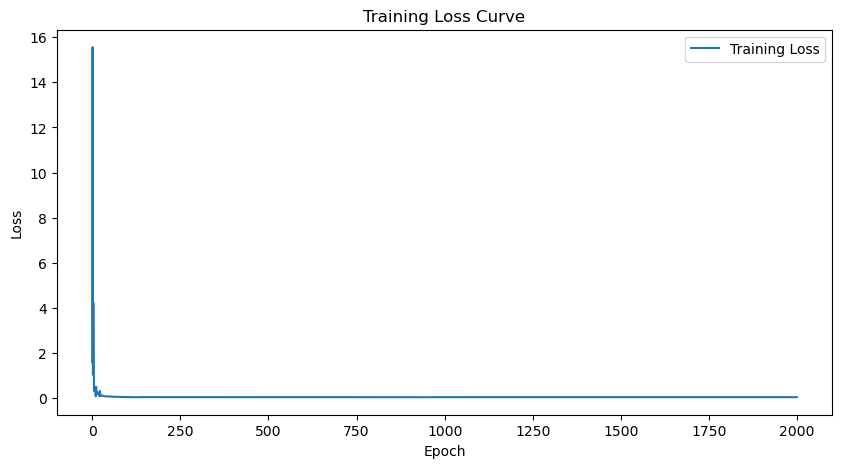

Final Model Accuracy: 98.98%
Final Model F1-score: 0.9899


In [9]:
input_dim = X_train.shape[1]
hidden_dim = 256

custom_mlp, losses, best_accuracy, best_f1 = train_model(X_train, y_train, X_test, y_test, input_dim, hidden_dim)

In [10]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved to '{filepath}'.")

save_checkpoint(custom_mlp, torch.optim.Adam(custom_mlp.parameters()), len(losses), losses[-1], checkpoint_file)

Checkpoint saved to '/home/guangwei/LLM-COPYRIGHT/copyright_newVersion/models/train_input_last_token.pth'.


In [ ]:
y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()
print(classification_report(y_test, y_pred_final, target_names=["infringement", "non_infringement"]))

                  precision    recall  f1-score   support

    infringement       1.00      0.98      0.99        49
non_infringement       0.98      1.00      0.99        49

        accuracy                           0.99        98
       macro avg       0.99      0.99      0.99        98
    weighted avg       0.99      0.99      0.99        98



/tmp/ipykernel_3618815/2137335780.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_final = (torch.sigmoid(torch.tensor(custom_mlp(torch.tensor(X_test, dtype=torch.float32)))) > 0.5).float().numpy()


: 